In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import yaml
import os
from datetime import datetime
import numpy as np
from utils import get_config, resolve_path
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Custom modules
from dataset2 import APOGEEDataset
from model2 import Generator
from tqdm import tqdm
from checkpoint import save_checkpoint, load_checkpoint

In [2]:
def initialize_device():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    return device

In [3]:
def load_configurations():
    config = get_config()
    data_path = resolve_path(config['paths']['hdf5_data'])
    checkpoints_path = resolve_path(config['paths']['checkpoints'])
    latent_path = resolve_path(config['paths']['latent'])
    plots_path = resolve_path(config['paths']['plots'])
    tensorboard_path = resolve_path(config['paths']['tensorboard'])

    batch_size = config['training']['batch_size']
    num_workers = config['training']['num_workers']
    num_epochs = config['training']['num_epochs']
    learning_rate = config['training']['learning_rate']
    latent_learning_rate = config['training']['latent_learning_rate']
    latent_dim = config['training']['latent_dim']
    checkpoint_interval = config['training']['checkpoint_interval']

    return (config, data_path, checkpoints_path, latent_path, plots_path, tensorboard_path,
            batch_size, num_workers, num_epochs, learning_rate, latent_learning_rate, latent_dim, checkpoint_interval)

In [4]:
def weighted_mse(input, target, weight):
    assert input.shape == target.shape == weight.shape, f'Shapes of input {input.shape}, target {target.shape}, and weight {weight.shape} must match'
    loss = torch.mean(weight * (input - target) ** 2)
    return loss

In [5]:
def plot_real_vs_generated_batch(checkpoints_path, latent_path, data_loader, generator, device, batch_index, plots_path):
    # Load the latest latent codes
    latent_files = sorted(os.listdir(latent_path))
    last_latent_file = os.path.join(latent_path, latent_files[-1])
    latents = np.load(last_latent_file, allow_pickle=True).item()
    
    # Find the specific batch
    batch = None
    for i, batch_data in enumerate(data_loader):
        if i == batch_index:
            batch = batch_data
            break

    # Ensure the batch is found
    if batch is None:
        raise ValueError(f"Batch index {batch_index} not found in the data loader.")
    
    # Extract the indexes and spectra from the batch
    indices = batch['index']
    real_spectra = batch['flux']
    masks = batch['flux_mask']
    
    # Generate the spectra using the generator model
    generator.eval()
    with torch.no_grad():
        latent_codes = torch.tensor(latents['latent_codes'][indices]).to(device)
        generated_spectra = generator(latent_codes).cpu().numpy()
    
    # Plot real vs generated spectra for each index in the batch
    for i, index in enumerate(indices):
        real_spectrum = real_spectra[i].cpu().numpy()
        generated_spectrum = generated_spectra[i]
        mask = masks[i].cpu()

        mse = weighted_mse(torch.tensor(generated_spectrum), torch.tensor(real_spectrum), mask).item()

        
        plt.figure(figsize=(10, 5))
        plt.plot(real_spectrum, label='Real Spectrum', color='blue', alpha=0.7, linewidth=0.5)
        plt.plot(generated_spectrum, label='Generated Spectrum', color='red', alpha=0.7, linewidth=0.5)
        plt.title(f'Comparison of Real and Generated Spectra for Spectrum Index {index}\nMasked MSE: {mse:.4f}')
        plt.ylim(0,1.2)
        plt.xlabel('Wavelength Index')
        plt.ylabel('Flux')
        plt.legend()
        plt.grid(True)
        
        plt.savefig(os.path.join(plots_path, f'real_vs_generated_{index}.png'))

        plt.show()
        plt.close()

initializing device ..
Using device: cpu
loading config..


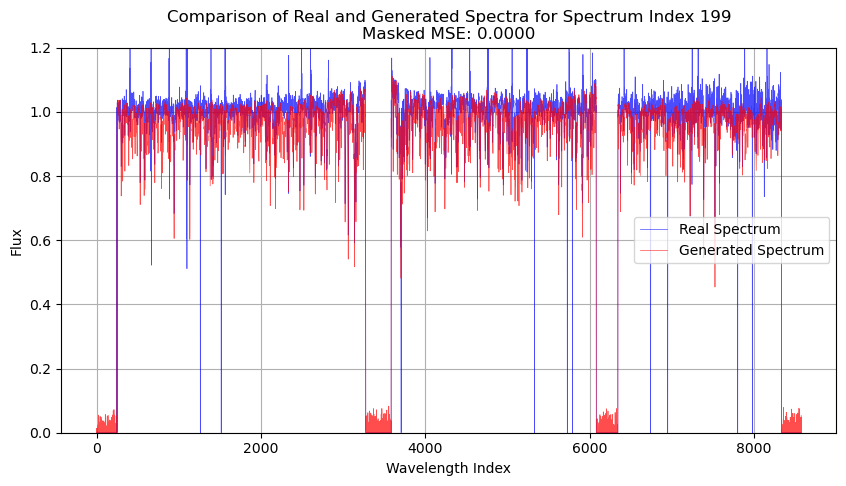

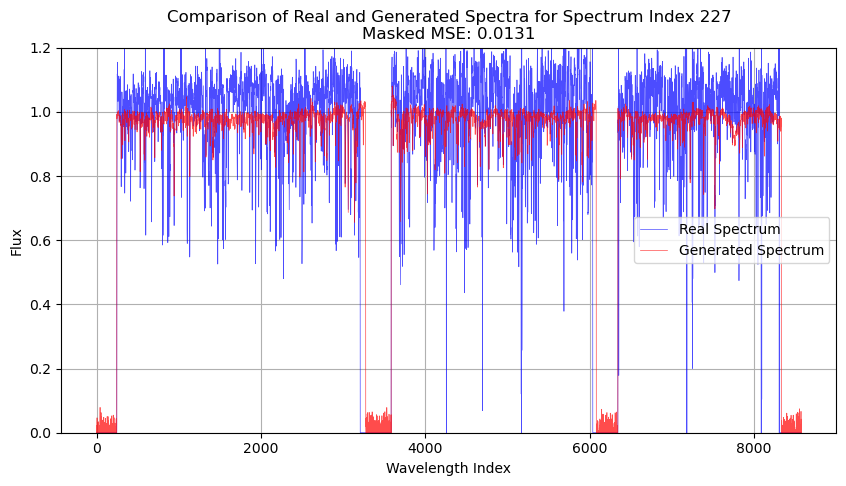

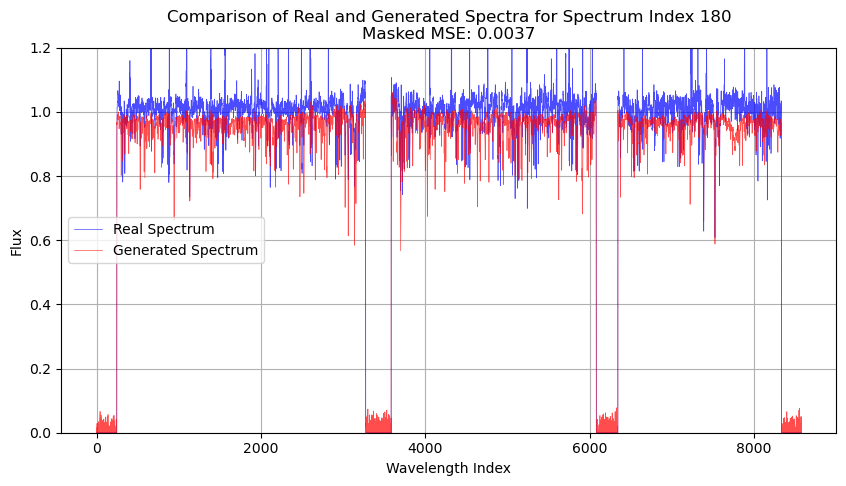

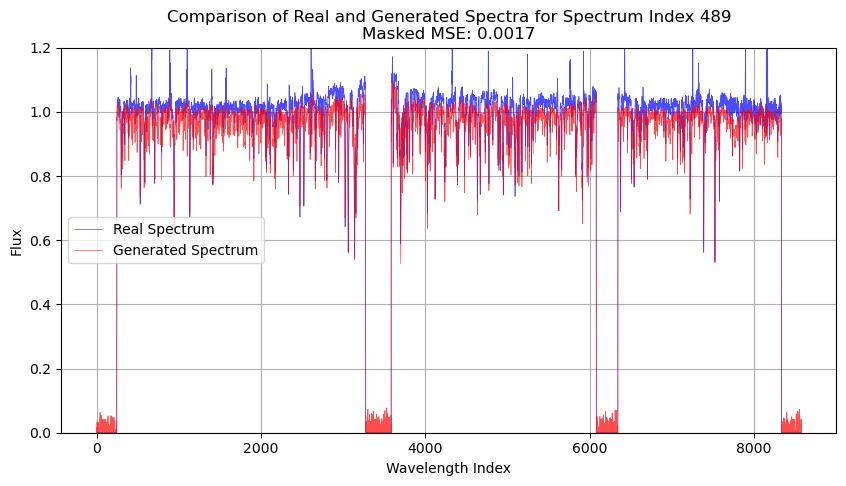

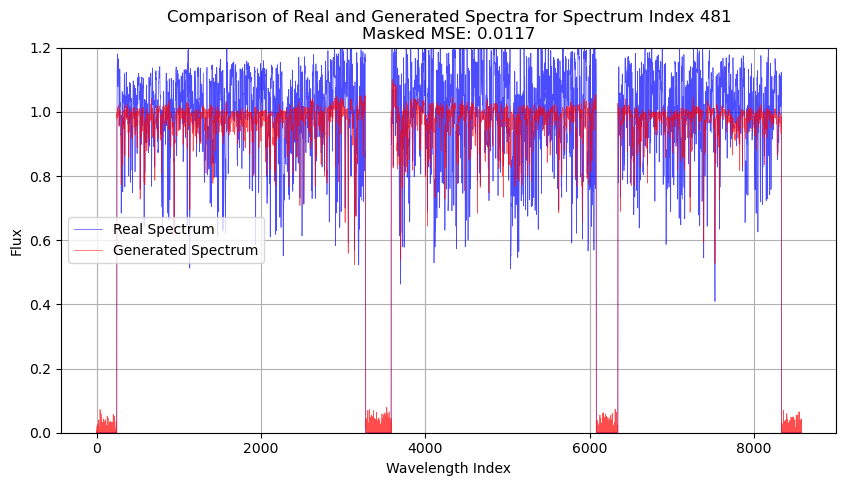

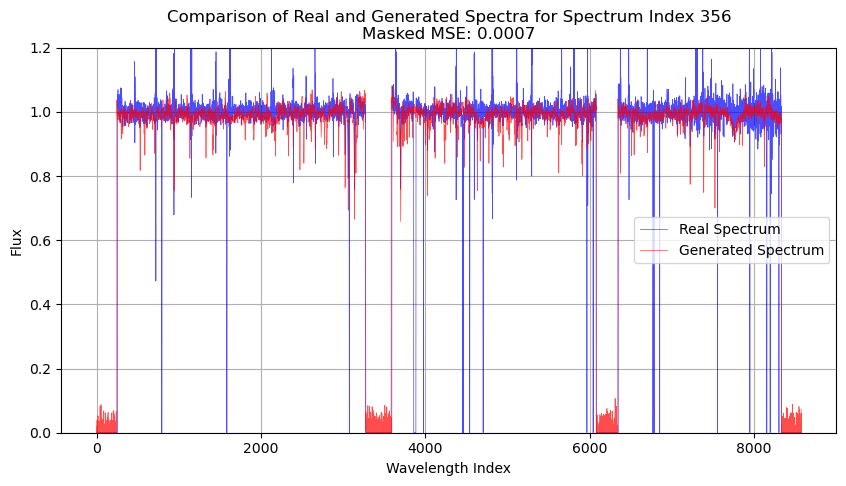

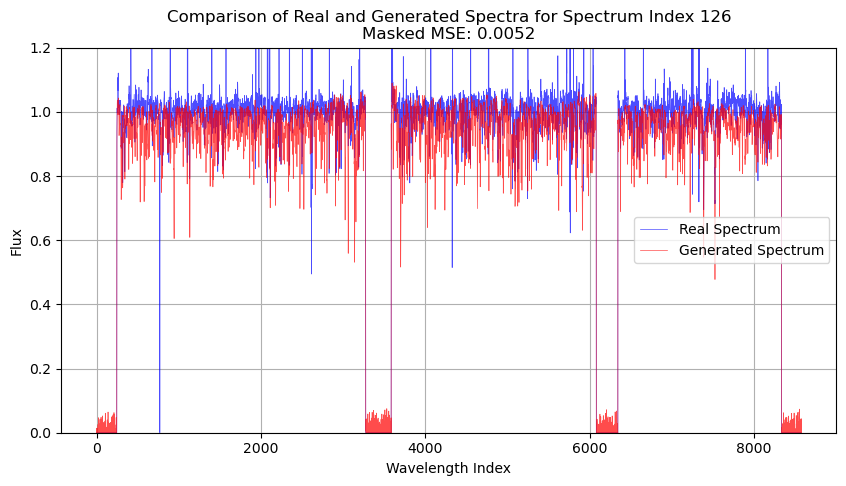

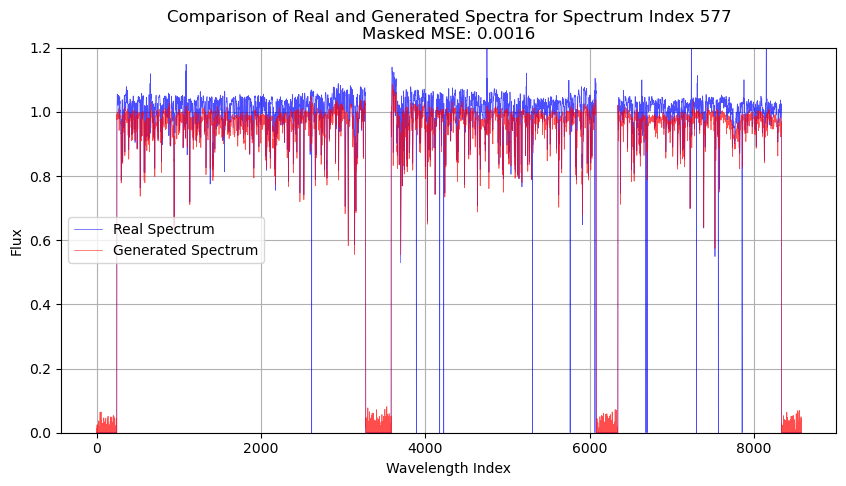

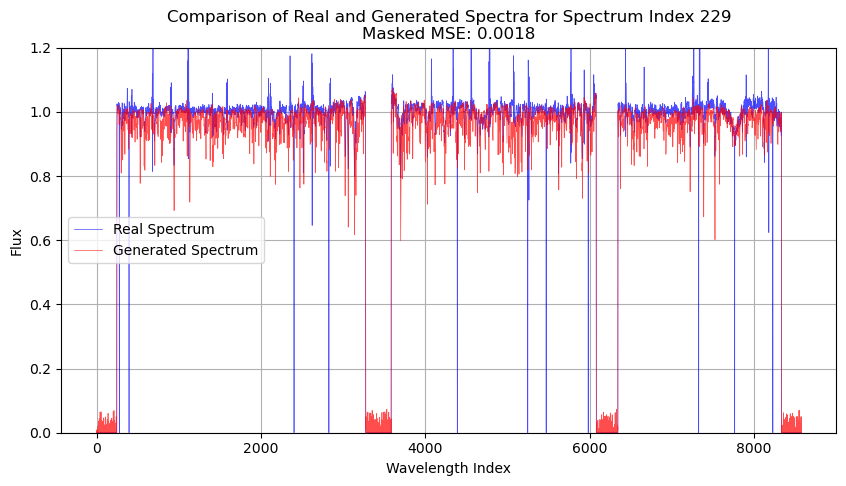

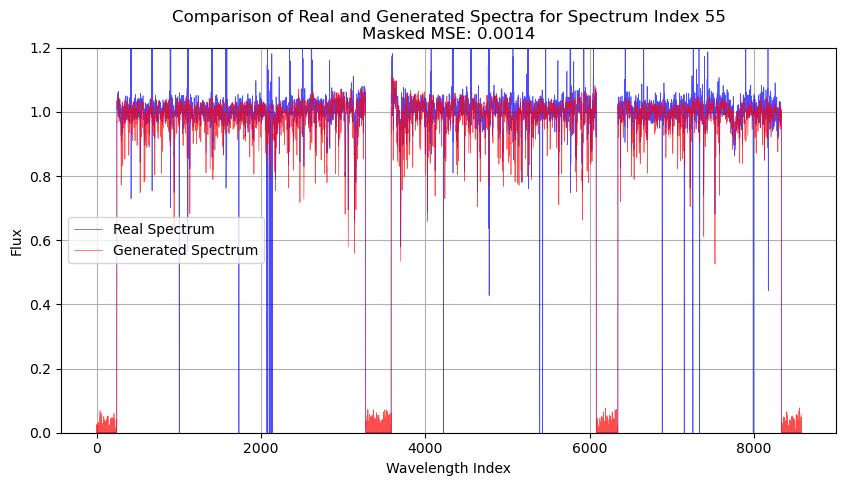

In [6]:
print("initializing device ..")
device = initialize_device()
print("loading config..")
(config, data_path, checkpoints_path, latent_path, plots_path, tensorboard_path,
 batch_size, num_workers, num_epochs, learning_rate, latent_learning_rate, latent_dim, checkpoint_interval) = load_configurations()

# Initialize the dataset and data loader
dataset = APOGEEDataset(data_path, max_files=config['training']['max_files'])
train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)

# Initialize the generator model
generator = Generator(config['training']['latent_dim'], config['model']['output_dim'], config['model']['generator_layers'], config['model']['activation_function']).to(device)

# Load the latest checkpoint if available
latest_checkpoint_path = os.path.join(checkpoints_path, 'checkpoint_latest.pth.tar')
if os.path.exists(latest_checkpoint_path):
    checkpoint = torch.load(latest_checkpoint_path)
    generator.load_state_dict(checkpoint['state_dict'])

# Plot the real vs generated spectra for the batch of index batc_index
batch_index = 10
plot_real_vs_generated_batch(checkpoints_path, latent_path, train_loader, generator, device, batch_index, plots_path)

In [7]:
def plot_latent_evolution(latent_dir, spectrum_index, num_epochs, plots_path):
    latent_evolution = []

    for epoch in range(1, num_epochs + 1):
        latent_path = os.path.join(latent_dir, f'latent_codes_epoch_{epoch}.npy')
        latent_data = np.load(latent_path, allow_pickle=True).item()
        latent_codes = latent_data['latent_codes']
        latent_evolution.append(latent_codes[spectrum_index])

    latent_evolution = np.array(latent_evolution)

    plt.figure(figsize=(12, 8))
    for i in range(latent_evolution.shape[1]):
        plt.plot(latent_evolution[:, i], label=f'Latent Dimension {i + 1}')

    plt.title(f'Evolution of Latent Space for Spectrum Index {spectrum_index}')
    plt.xlabel('Epoch')
    plt.ylabel('Latent Value')
    plt.legend()
    plt.grid(True)
    plt.savefig(os.path.join(plots_path, f'latent_evolution_{spectrum_index}.png'))
    plt.show()

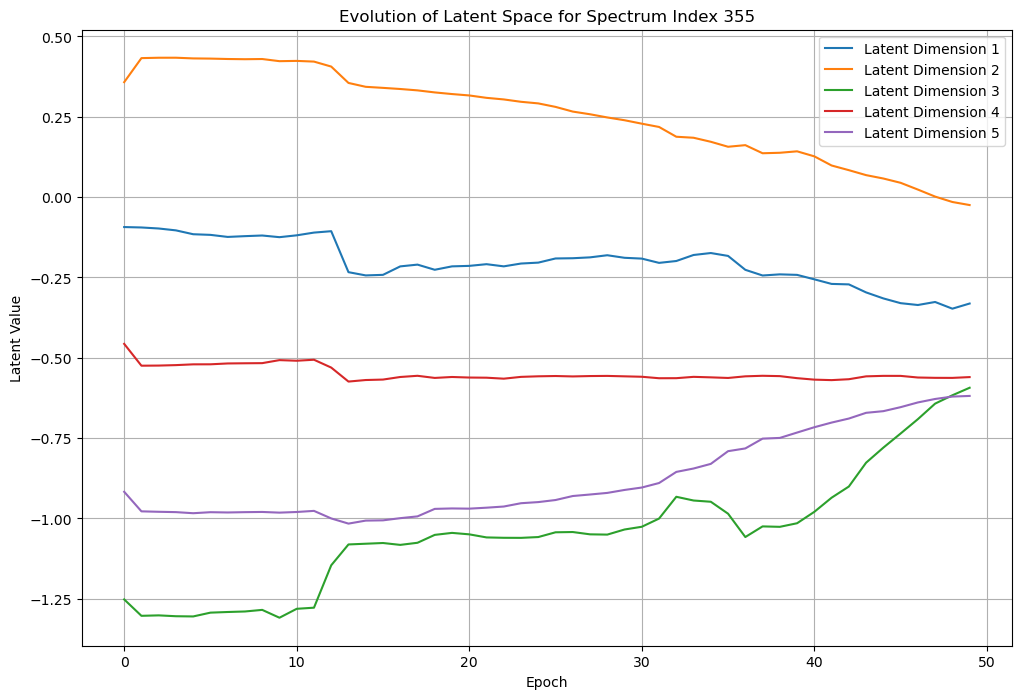

In [12]:
plot_latent_evolution(latent_path, 355, num_epochs, plots_path)